In [1]:
import torch

In [2]:
with open('unique_english_words.txt', 'r') as f:
    words = [word.rstrip() for word in f.readlines()] 

words[:3]

['uncinate', 'argute', 'elusive']

## Create the training set of all the bigrams

In [3]:
SPECIAL_TOKEN = '.'

In [4]:
unique_symbols = set(list(''.join(words)))
unique_symbols.add(SPECIAL_TOKEN)

stoi = {s: i for i, s in enumerate(unique_symbols)}
itos = {i: s for s, i in stoi.items()}

In [5]:
X = []
y = []

for word in words:
    word = SPECIAL_TOKEN + word + SPECIAL_TOKEN # Add special token in the begginning and in the end of each word
    for ch1, ch2 in zip(word, word[1:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]

        X.append(idx1)
        y.append(idx2)

X = torch.tensor(X)
y = torch.tensor(y)

print(X[:5], y[:5])

tensor([ 1, 18, 16, 25,  4]) tensor([18, 16, 25,  4, 16])


## One-hot encoding

In [6]:
unique_chars_num = len(unique_symbols)
unique_chars_num

28

In [7]:
import torch.nn.functional as F
X_enc = F.one_hot(X, num_classes = unique_chars_num).float()
X_enc.shape

torch.Size([9017, 28])

## Softmax explained

In [8]:
# create weights matrix which is represent single linear layer
# we have 28 input and 28 output (this can be num of neurons as well) 
W = torch.randn((unique_chars_num, unique_chars_num))

X_enc[:2] @ W

tensor([[ 1.0083, -0.1599, -1.4693,  0.8788,  0.5180,  0.0457, -0.2957,  1.6794,
          0.7590,  0.3541,  0.4715,  0.1588, -1.3286, -0.0857,  0.7065,  0.0481,
         -0.5914,  0.5495,  0.0344, -1.0729, -0.1298,  1.3277, -0.6477, -0.5158,
          1.1903,  0.6141,  0.2972,  0.7481],
        [-0.2463, -0.6501, -0.5154, -1.0536, -0.8390,  2.1327,  0.2512,  1.4136,
         -0.5462,  0.7345,  1.0448, -0.8706, -0.4226,  0.2607,  0.2804, -0.4514,
         -0.8138,  1.5651, -0.0115,  0.9336, -0.8722, -0.6852, -1.4283,  0.5084,
          0.1497,  1.0172, -1.5082, -1.0692]])

Ideally what we want to get is a probability distribution for the next character in a sequence. But at this moment some of given output numbers are positive, some - negative and we cannot interpret them this way.

<br>So we're gonna interpret these numbers as **LOG COUNTS**. To get the counts (we can transform counts to probabilities!) we need to `exponentiate output values` (all values always will be > 0 after exp()).

In [9]:
# negative vals are becoming 0 < val < 1 vals
# and positive vals are becoming even more positive (and > 1)
(X_enc[:2] @ W).exp()

tensor([[2.7410, 0.8522, 0.2301, 2.4081, 1.6787, 1.0468, 0.7440, 5.3622, 2.1361,
         1.4248, 1.6023, 1.1721, 0.2648, 0.9179, 2.0268, 1.0493, 0.5535, 1.7324,
         1.0350, 0.3420, 0.8782, 3.7723, 0.5232, 0.5970, 3.2882, 1.8481, 1.3461,
         2.1130],
        [0.7817, 0.5220, 0.5973, 0.3487, 0.4321, 8.4377, 1.2856, 4.1106, 0.5792,
         2.0843, 2.8428, 0.4187, 0.6554, 1.2979, 1.3237, 0.6367, 0.4432, 4.7830,
         0.9886, 2.5436, 0.4180, 0.5040, 0.2397, 1.6626, 1.1615, 2.7655, 0.2213,
         0.3433]])

And now we can interpret these values as counts. Now we can calculate `probabilities` based on these counts.

In [10]:
## THIS IS A SOFTMAX!

counts = (X_enc[:2] @ W).exp()
counts / counts.sum(axis = 1, keepdim = True)

tensor([[0.0627, 0.0195, 0.0053, 0.0551, 0.0384, 0.0240, 0.0170, 0.1227, 0.0489,
         0.0326, 0.0367, 0.0268, 0.0061, 0.0210, 0.0464, 0.0240, 0.0127, 0.0397,
         0.0237, 0.0078, 0.0201, 0.0864, 0.0120, 0.0137, 0.0753, 0.0423, 0.0308,
         0.0484],
        [0.0184, 0.0123, 0.0141, 0.0082, 0.0102, 0.1989, 0.0303, 0.0969, 0.0137,
         0.0491, 0.0670, 0.0099, 0.0154, 0.0306, 0.0312, 0.0150, 0.0104, 0.1127,
         0.0233, 0.0599, 0.0099, 0.0119, 0.0056, 0.0392, 0.0274, 0.0652, 0.0052,
         0.0081]])

## Single linear layer

How can we optimize `W` to obtain good reasonable but not random predictions?
<br>We need **LOSS FUNCTION**.

In [11]:
def neg_log_likelihood(y_true, y_pred):
    # y_true - indecies (e.g. [0, 2, 1])
    # y_pred - prob density (e.g. [[0.1, 0.1, 0.8], [0.1, 0.1, 0.8], [0.1, 0.1, 0.8]])
    
    assert y_true.shape[0] == y_pred.shape[0], "'y' shapes doesn't match!"
    
    n = y_true.shape[0]
    prob = y_pred[torch.arange(n), y_true]
    log_prob = prob.log()
    log_likelihood = log_prob.mean()
    return -log_likelihood

In [12]:
# --------------initialize the weights--------------
# create a generator for reproducible results
g = torch.Generator().manual_seed(23)
W = torch.randn((unique_chars_num, unique_chars_num), 
                generator = g, 
                requires_grad = True)

In [13]:
n_iter = 10_000

loss_list = []
for i in range(n_iter):
    # --------------forward pass--------------
    logits = X_enc @ W

    # apply softmax
    counts = logits.exp()
    probs = counts / counts.sum(dim = 1, keepdim = True)

    # calculate loss
    loss = neg_log_likelihood(y, probs)
    loss_list.append(loss.item())

    # --------------backward pass--------------
    W.grad = None
    loss.backward()

    # update weights
    W.data += -1 * W.grad
    

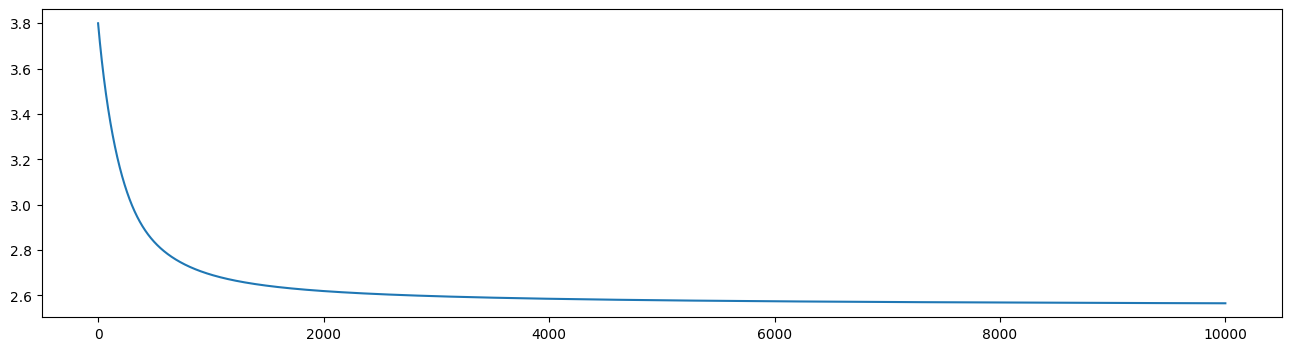

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 4))
plt.plot(loss_list)

In [15]:
loss_list[-5:]

[2.565664529800415,
 2.5656633377075195,
 2.565661668777466,
 2.5656607151031494,
 2.565659284591675]

The best loss we can get is somewhere around the loss we obtained for a simple bigram model which is `normilized negative log-likelihood = 2.582085132598877`!

## Predictions!

In [16]:
g = torch.Generator().manual_seed(55)

# let's generate some new unique English words!
for i in range(20):
    word = []
    idx = stoi[SPECIAL_TOKEN] # any word always starts with special token '.'
    while True:

        # one-hot encoding of prev character
        x_enc = F.one_hot(torch.tensor([idx]), num_classes = unique_chars_num).float()
        
        ## forward pass
        logits = x_enc @ W

        # apply softmax
        counts = logits.exp()
        probs = counts / counts.sum(dim = 1, keepdim = True)

        idx = torch.multinomial(probs, num_samples = 1, replacement = True, generator = g).item()
        if idx == stoi[SPECIAL_TOKEN]: # if we meet special token - it is the end of the word!
            break  
        word.append(itos[idx])

    print(''.join(word))

p
acak
protonus
ilul
cosnghodhanalaltin
moudous
e
nt
e
mantybbis
blbllop
antyacalouroouacigas
flljoxypinckenis
pesatolousciofffawhasystingoumarpxtrarup
veral
fet
e
sing
bult
e


In [17]:
# wsausus
# umpun
# cenuroscot
# dalyoloap-whenuciack
# jugind
# zocankammllisiman
# c
# cericb
# wbusobousty
# bschaibunuen
# uine
# stataptomatkebrrrupll
# gthifqk
# cudlf
# w-uplskoroul
# uppeatingloumapuingmopywallisoulellen
# plelisiveriniqud
# kscombuitripsenntususcurdoucefee
# y
# spaburisherostiscenchornored